# 提升树算法

提升方法实际上是采用加法模型，即基函数的线性组合与前向分布算法来进行的一类算法，事实证明，该算法具有很好的拟合性能。
算法如下

1. 初始化 $f_0(x)=0$
2. 对m=1,2,3,...M求残差（一般为平方误差 如果是分类问题就交叉熵误差）
3. 拟合残差学习新的回归树
4. 更新 $f_m(x)=f_{m-1}(x)+T(x;\theta_m)$
5. 直到误差小于我们规定的误差停止


上面的是普通提升树的算法，而GBDT为梯度提升，什么意思呢，在刚刚算的残差之后，我们使用的简单的损失函数，如果是复杂的损失函数，优化并不简单的，于是提出了一种梯度上升算法，也就是使用损失函数的负梯度在当前模型的值作为回归树问题算法的残差的近似值，来拟合回归树。

In [1]:
import numpy as np
import math

In [3]:

# 计算信息熵
def calculate_entropy(y):
    log2 = math.log2
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy
# 定义树的节点
class DecisionNode():
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          
        self.threshold = threshold         
        self.value = value                 
        self.true_branch = true_branch     
        self.false_branch = false_branch
def divide_on_feature(X, feature_i, threshold):
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])
# 超类
class DecisionTree(object):
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  #根节点
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        # 计算值 如果是分类问题就是信息增益，回归问题就基尼指数
        self._impurity_calculation = None
        self._leaf_value_calculation = None #计算叶子
        self.one_dim = None
        self.loss = loss

    def fit(self, X, y, loss=None):
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """
        递归求解树
        """

        largest_impurity = 0
        best_criteria = None
        best_sets = None
        
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # 计算每一个特征的增益值
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                for threshold in unique_values:
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)
                    
                    if len(Xy1) > 0 and len(Xy2) > 0:
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # 计算增益值
                        impurity = self._impurity_calculation(y, y1, y2)

                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],  
                                "lefty": Xy1[:, n_features:],   
                                "rightX": Xy2[:, :n_features],  
                                "righty": Xy2[:, n_features:]   
                                }

        if largest_impurity > self.min_impurity:
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)
        
        # 计算节点的目标值
        leaf_value = self._leaf_value_calculation(y)
        
        
        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """
        预测
        """

        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature_i]

        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        return self.predict_value(x, branch)

    def predict(self, X):
        y_pred = []
        for x in X:
            y_pred.append(self.predict_value(x))
        return y_pred
def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # 使用方差缩减
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

In [11]:
class GradientBoosting(object):
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in range(self.n_estimators):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Update y prediction
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred

In [32]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
# 如果是回归模型
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)
# 如果是分类模型
class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)

In [33]:
class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

In [13]:
import pandas as pd

In [14]:
data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

time = np.atleast_2d(data["time"].as_matrix()).T
temp = np.atleast_2d(data["temp"].as_matrix()).T

X = time.reshape((-1, 1))               # Time. Fraction of the year [0, 1]
X = np.insert(X, 0, values=1, axis=1)   # Insert bias term
y = temp[:, 0]    

In [15]:
from sklearn.cross_validation import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [19]:
class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

In [20]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_line = model.predict(X)

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
mse = mean_squared_error(y_test, y_pred)

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

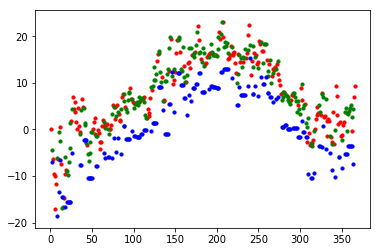

In [31]:
m1 = plt.scatter(366 * X_train[:, 1],y_train, c='r',s=10)
m2 = plt.scatter(366 * X_test[:, 1], y_test,c='g',s=10)
m3 = plt.scatter(366 * X_test[:, 1], y_pred,c='b',s=10)

### 分类模型

In [34]:
class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

In [35]:
def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [38]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
data = datasets.load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

/Users/haxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp
/Users/haxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [39]:
accuracy

0.93333333333333335